# LinearModelV0 with ZeroShotDataset

This notebook is an experimental approach on solving the ARC challenge. See https://arcprize.org/ for more details.

In [1]:
import os
import random

import torch

from pathlib import Path

from arc2024.data import ZeroShotDataset
from arc2024.utils import plot
from arc2024.utils.calc import accuracy_fn, norm_arc20204
from arc2024.models.linear import LinearModelV0

# Setup Device Agnostic Environment

In [2]:
import arc2024.utils.amdgpu as amd

if amd.is_amdgpu_on_linux():
    # Use ROCm on rx6600/6600xt by setting the environment variable HSA_OVERRIDE_GFX_VERSION to "10.3.0"
    # Source: https://github.com/ROCm/ROCm/issues/1698#issuecomment-1261646854
    amd.setup_amdgpu_environment(
        hsa_override_gfx_version="10.3.0"
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Prepare Datasets and DataLoaders

In [3]:
dataset_dir = Path('datasets')

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataset = ZeroShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='training',
    mode='train',
    permutations_enabled=True
)
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataset = ZeroShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='training',
    mode='test'
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

TypeError: ZeroShotDataset.__init__() got an unexpected keyword argument 'permutations'

## Train Model

In [6]:
model = LinearModelV0(
    in_features=900, # 30x30
    hidden_features=600, # do some compression
    out_features=900
).to(device)
model

LinearModelV0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=900, out_features=600, bias=True)
  (linear2): Linear(in_features=600, out_features=900, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(1, 30, 30))
)

### Verify Input and Output Shapes with Random Tensor

In [5]:
x = torch.rand([1, 30, 30]).to(device)
model(x).shape

torch.Size([1, 1, 30, 30])

In [6]:
X, y = train_dataset[0]
X = X.to(device) / 10
y = y.to(device) / 10

y_pred = model(X)
y_pred, y_pred.shape

(tensor([[[[-4.8337e-01,  4.8315e-01,  3.6437e-01, -5.6359e-01,  6.2014e-01,
            -6.7032e-02,  1.7201e-02, -7.0121e-02, -4.7959e-01, -1.2394e-01,
            -1.4778e-01,  9.1916e-01, -2.1771e-01,  5.1516e-01, -1.6900e-01,
            -6.5748e-02,  2.2605e-02, -2.5891e-01, -2.5802e-01,  4.5856e-02,
            -7.2338e-02,  7.2264e-01, -1.8200e-01,  1.4919e-02, -8.3140e-02,
             2.1500e-01, -1.9390e-02, -5.4412e-01, -5.0965e-02,  7.0793e-01],
           [-2.0728e-02,  5.4514e-01, -6.0683e-02,  5.9501e-02, -7.4433e-01,
            -6.7553e-01,  3.9786e-01, -1.4026e-01,  3.6978e-01,  4.1006e-02,
             1.7110e-01, -2.1978e-01, -2.0643e-01, -4.7765e-01,  4.7733e-02,
            -1.2846e-01,  4.2846e-01, -4.5792e-02,  5.1822e-01, -9.4144e-02,
            -3.6969e-01, -1.2886e-01,  2.8938e-01, -1.5998e-01,  2.9505e-01,
             6.1630e-01,  1.5193e-01,  3.0220e-01,  2.7131e-01, -6.6088e-02],
           [-8.5810e-02, -4.4198e-02,  4.2329e-01, -1.8665e-01,  5.3957e-0

### Setup Loss, optimizer and evaluation metrics

In [7]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

### Run Training Loop

In [8]:
from timeit import default_timer as timer 

epochs = 50

time_start = timer()
for epoch in range(epochs):
    ### Training
    train_loss = 0
    train_accuracy = 0

    model.train() # Set model into training mode
    
    for b, (X_train, y_train) in enumerate(train_dataloader):
        # Send to device and normalize:
        X_train, y_train = X_train.to(device) / 10, y_train.to(device) / 10
        
        # Forward pass:
        train_pred = model(X_train)
        
        # Calculate loss:
        loss = loss_fn(train_pred, y_train)
        train_loss += loss
        train_accuracy += accuracy_fn(y_train, norm_arc20204(train_pred))
        
        # Reset optimizer gradients:
        optimizer.zero_grad()
        
        # Backward pass:
        loss.backward()
        
        # Adjust parameters:
        optimizer.step()

    train_loss /= len(train_dataloader.dataset)
    train_accuracy /= len(train_dataloader.dataset)
    
    ### Testing
    test_loss = 0
    test_accuracy = 0
    model.eval() # set model into evaluation mode

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # Send to device and normalize:
            X_test, y_test = X_test.to(device) / 10, y_test.to(device) / 10

            # Forward pass:
            test_pred = model(X_test)

            # Calculate loss:
            loss = loss_fn(test_pred, y_test)
            test_loss += loss
            test_accuracy += accuracy_fn(y_test, norm_arc20204(test_pred))
    
        test_loss /= len(test_dataloader.dataset)
        test_accuracy /= len(test_dataloader.dataset)
    
    print(f"Epoch {epoch + 1}/{epochs} | Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}%")
time_end = timer()

print(f"Total time taken: {time_end - time_start}")

Epoch 1/50 | Train loss: 0.00444 | Train accuracy: 0.04% | Test loss: 0.00222 | Test accuracy: 0.03%
Epoch 2/50 | Train loss: 0.00094 | Train accuracy: 0.04% | Test loss: 0.00216 | Test accuracy: 0.03%
Epoch 3/50 | Train loss: 0.00092 | Train accuracy: 0.05% | Test loss: 0.00213 | Test accuracy: 0.03%
Epoch 4/50 | Train loss: 0.00090 | Train accuracy: 0.04% | Test loss: 0.00208 | Test accuracy: 0.03%
Epoch 5/50 | Train loss: 0.00089 | Train accuracy: 0.05% | Test loss: 0.00205 | Test accuracy: 0.03%
Epoch 6/50 | Train loss: 0.00088 | Train accuracy: 0.04% | Test loss: 0.00202 | Test accuracy: 0.03%
Epoch 7/50 | Train loss: 0.00087 | Train accuracy: 0.04% | Test loss: 0.00198 | Test accuracy: 0.03%
Epoch 8/50 | Train loss: 0.00085 | Train accuracy: 0.04% | Test loss: 0.00196 | Test accuracy: 0.03%
Epoch 9/50 | Train loss: 0.00084 | Train accuracy: 0.05% | Test loss: 0.00192 | Test accuracy: 0.03%
Epoch 10/50 | Train loss: 0.00084 | Train accuracy: 0.05% | Test loss: 0.00191 | Test accur

# Evaluate Model

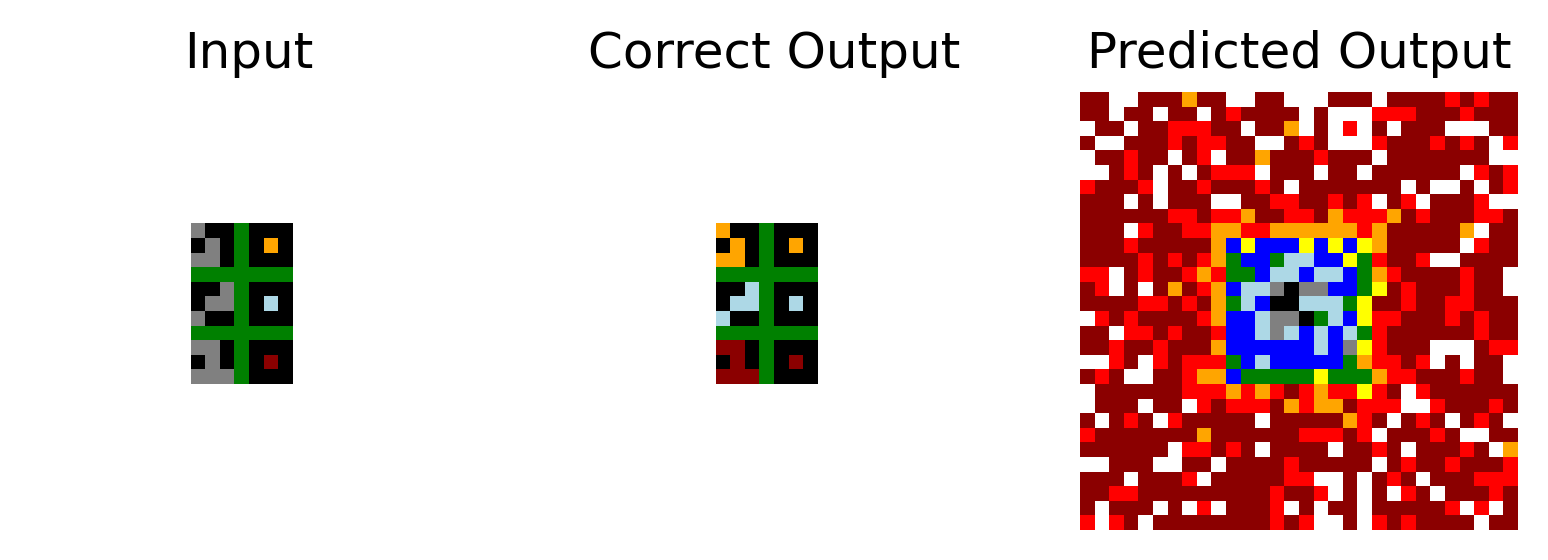

Accuracy: 1.78% (16/900)


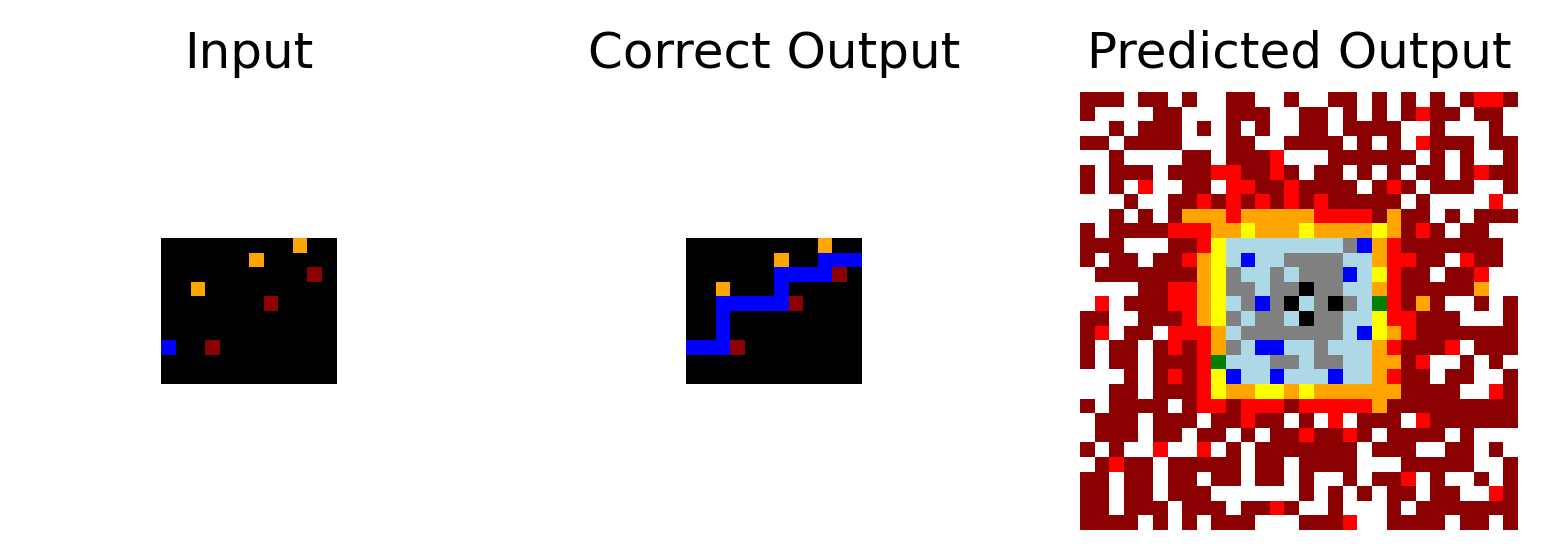

Accuracy: 2.33% (21/900)


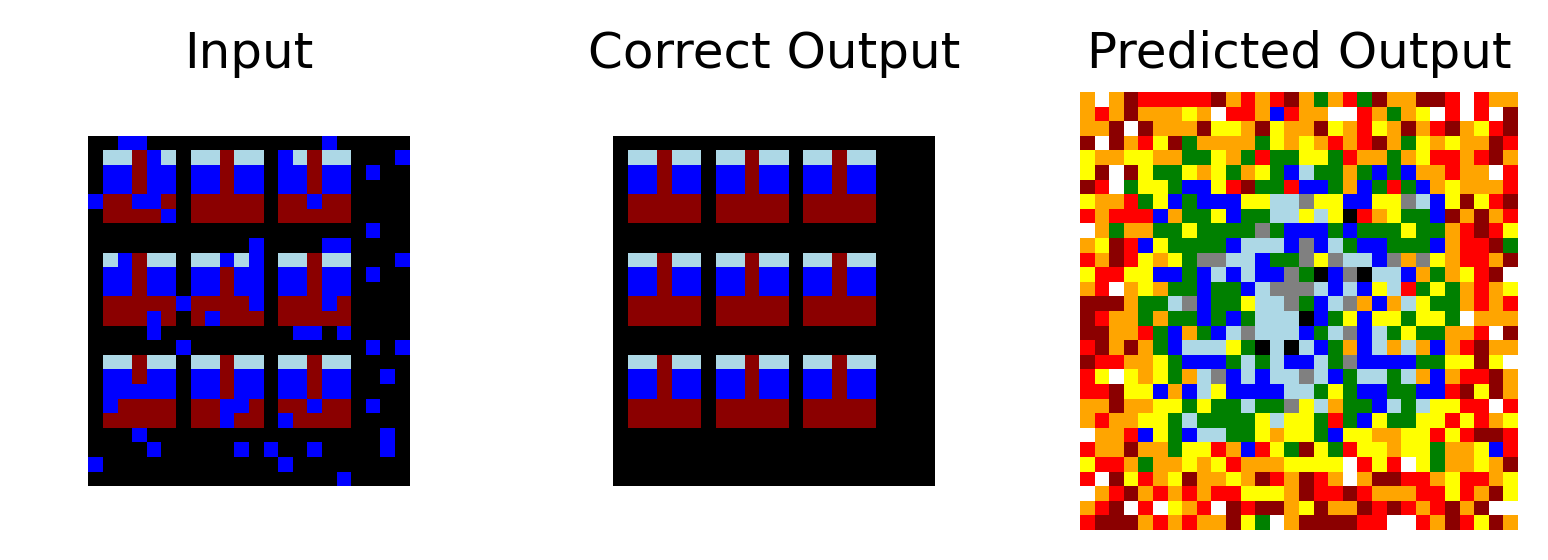

Accuracy: 3.33% (30/900)


In [9]:
evaluations = 3

evaluation_dataset = ZeroShotDataset(
    dataset_dir=dataset_dir,
    dataset_name='evaluation',
    mode='test'
)

model.eval() # set model into evaluation mode
with torch.inference_mode():
    
    for _ in range(evaluations):
        X, y = random.choice(evaluation_dataset)
        X, y = X.to(device) / 10, y.to(device) / 10
        
        y_pred = model(X)[0]
        y_pred_norm = norm_arc20204(y_pred)
        
        plot.input_and_output(X * 10, y * 10, y_pred_norm * 10)
        accuracy_pred = accuracy_fn(y, y_pred_norm)
        print(f"Accuracy: {accuracy_pred:.2f}% ({int(accuracy_pred / 100 * 900)}/900)")
